In [1]:
import os
import lenspyx
from lenspyx.utils import camb_clfile
import healpy as hp
import numpy as np
import matplotlib.pyplot as pl
import pymaster as nmt
import pickle as pk
import emcee
import corner

In [2]:
import sys
sys.path.append('/global/u2/l/lonappan/workspace/s4bird/s4bird/validations_dir')
from noise import noise_realisation
sys.path.append('../../')
from likelihood import cosmology

In [3]:
cl_len = camb_clfile('/project/projectdirs/litebird/simulations/S4BIRD/CAMB/s4bird_lensedCls.dat')
cl_unl = camb_clfile('/project/projectdirs/litebird/simulations/S4BIRD/CAMB/s4bird_lenspotentialCls.dat')
ini = '/project/projectdirs/litebird/simulations/S4BIRD/CAMB/CAMB.ini'

In [4]:
lmax = 4096
dlmax = 1024
nside = 2048 
facres = -1

In [5]:
plm = hp.synalm(cl_unl['pp'], lmax=lmax + dlmax, new=True)

In [6]:
dlm = hp.almxfl(plm, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)))

In [7]:
elm_unl = hp.synalm(cl_unl['ee'], lmax=lmax + dlmax, new=True)
Qlen, Ulen  = lenspyx.alm2lenmap_spin([elm_unl, None], [dlm, None], nside, 2, facres=facres)

BAND 0 in 8 :
resolve_poles: I have flipped 1 signs out of 2 pixels on south pole
input t1,t2 -0.304 11.659 in degrees
North 18.734 and South 18.688 buffers in amin
cell (theta,phi) in amin (1.874,1.066)
BAND 1 in 8 :
input t1,t2 10.846 22.912 in degrees
North 18.868 and South 18.859 buffers in amin
cell (theta,phi) in amin (1.890,1.027)
BAND 2 in 8 :
input t1,t2 22.096 34.207 in degrees
North 18.907 and South 18.972 buffers in amin
cell (theta,phi) in amin (1.897,1.482)
BAND 3 in 8 :
input t1,t2 33.331 45.439 in degrees
North 18.910 and South 18.934 buffers in amin
cell (theta,phi) in amin (1.897,0.939)
BAND 4 in 8 :
input t1,t2 44.592 56.670 in degrees
North 18.921 and South 18.876 buffers in amin
cell (theta,phi) in amin (1.892,1.102)
BAND 5 in 8 :
input t1,t2 55.832 67.931 in degrees
North 18.954 and South 18.908 buffers in amin
cell (theta,phi) in amin (1.895,1.222)
BAND 6 in 8 :
input t1,t2 67.089 79.154 in degrees
North 18.877 and South 18.900 buffers in amin
cell (theta,phi) in

In [8]:
noise = noise_realisation(nside,1.5,2.15,0)

In [9]:
noise[2].shape

(50331648,)

In [10]:
Qlen = hp.smoothing(Qlen,np.radians(.5))+ noise[1]
Ulen = hp.smoothing(Ulen,np.radians(.5))+ noise[2]

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 12.739827 arcmin (0.003706 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 30.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [11]:
elm_len, blm_len = hp.map2alm_spin([Qlen, Ulen], 2, lmax=lmax)

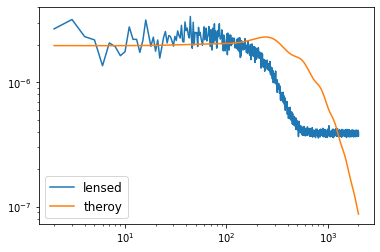

In [12]:
ell = np.arange(2,2000)
pl.figure()
pl.loglog(ell, hp.alm2cl(blm_len)[ell], label='lensed')
pl.loglog(ell, cl_len['bb'][ell], label='theroy')
pl.legend(fontsize=12)

In [13]:
wk = nmt.NmtWorkspace()

In [14]:
mask = hp.read_map('/global/u2/l/lonappan/workspace/S4bird/Data/masks/cmbs4_512_apo_C1_10.fits.gz')

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [15]:
f2  = nmt.NmtField(mask, [hp.ud_grade(Qlen,512), hp.ud_grade(Ulen,512)], purify_b=True)

In [16]:
b = nmt.NmtBin.from_nside_linear(512, 10)

In [17]:
wk.compute_coupling_matrix(f2, f2, b)

In [18]:
cw = nmt.NmtCovarianceWorkspace()

In [19]:
cw.compute_coupling_coefficients(f2, f2, f2, f2)

In [20]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [21]:
cl_22 = compute_master(f2,f2,wk)

In [22]:
n_ell = len(cl_22[0])

In [23]:
cl_ee = cl_len['ee'][:b.lmax+1]
cl_eb = 0*cl_ee
cl_bb = cl_len['bb'][:b.lmax+1]


covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      wk, wb=wk).reshape([n_ell, 4,
                                                            n_ell, 4])

In [24]:
covar_BB_BB = covar_22_22[:, 3, :, 3]

In [25]:
pk.dump(covar_BB_BB,open('cov_len_s4.pkl','wb'))

In [26]:
cov_inv = np.linalg.inv(covar_BB_BB)

In [27]:
yer = np.sqrt(np.diag(covar_BB_BB))

In [26]:
cl_22[3]

array([3.59759962e-05, 7.23338791e-07, 2.08602516e-06, 2.49016231e-06,
       2.50450708e-06, 2.49894692e-06, 2.48960491e-06, 1.87769984e-06,
       2.41044395e-06, 2.04415884e-06, 2.07843326e-06, 2.16296413e-06,
       2.10371601e-06, 1.90840485e-06, 2.09242483e-06, 2.00973741e-06,
       1.84360201e-06, 1.77649287e-06, 1.75000321e-06, 1.67753351e-06,
       1.67964529e-06, 1.57764886e-06, 1.50866262e-06, 1.39008622e-06,
       1.35754184e-06, 1.31620134e-06, 1.36271898e-06, 1.19890690e-06,
       1.09175508e-06, 1.05846011e-06, 1.01716211e-06, 9.56153623e-07,
       9.02304585e-07, 8.50045124e-07, 7.54263052e-07, 7.68394701e-07,
       7.08854239e-07, 6.79350855e-07, 6.47015459e-07, 5.96941382e-07,
       5.87530195e-07, 5.62474699e-07, 5.52668311e-07, 5.32959454e-07,
       5.13854363e-07, 4.88721258e-07, 4.93456149e-07, 4.84757962e-07,
       4.39071124e-07, 4.45857775e-07, 4.30920716e-07, 4.45539815e-07,
       4.10956571e-07, 3.94443023e-07, 4.21604982e-07, 4.08091123e-07,
      

In [27]:
pk.dump(cl_22[3],open('c_len_s4.pkl','wb'))

(0.0, 100.0)

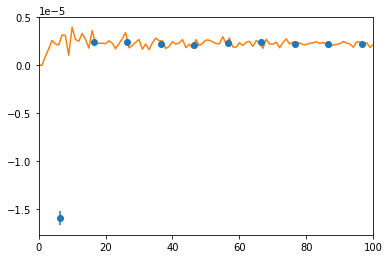

In [30]:

pl.errorbar(b.get_effective_ells(),cl_22[3],yerr=yer,fmt='o' )
pl.plot(hp.alm2cl(blm_len))
pl.xlim(0,100)

In [31]:
lmin = 30
lmax = 180

In [32]:
ell_e = b.get_effective_ells()
sel  = np.where((ell_e < lmax) & (ell_e >lmin))[0]

In [33]:
imin = sel[0]
imax = sel[-1]+1

In [34]:
len(sel)

15

In [35]:
covar_BB_BB[imin:imax,imin:imax].shape

(15, 15)

In [36]:
cos = cosmology('/global/u2/l/lonappan/workspace/S4bird/Notebooks/Likelihood/Test/',2048,10,ini,True)

In [37]:
bb_lensing = cos.get_BB('S',r=0)

returning cache


In [38]:
bb_tensor = cos.get_BB('T',1)

returning cache


/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(1e-06, 3.469023500264554e-06)

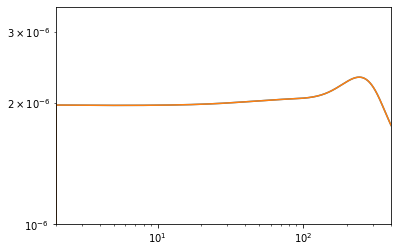

In [39]:
ell = np.arange(len(bb_lensing))
dl = ell*(ell+1)/(2*np.pi)
pl.loglog(bb_lensing/dl)
pl.loglog(cl_len['bb'])
pl.xlim(2,400)
pl.ylim(10**-6,None)

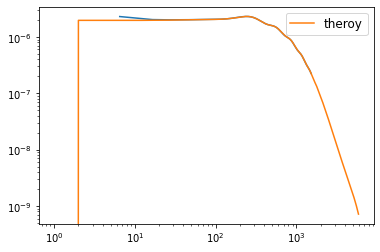

In [40]:
dl = ell_e*(ell_e+1)/(2*np.pi)
dl2 = ell*(ell+1)/(2*np.pi)
pl.loglog(ell_e,b.bin_cell(bb_lensing[:b.lmax+1])/dl)
pl.loglog(ell, cl_len['bb'][ell], label='theroy')
#pl.loglog(ell,cos.get_BB('S')[ell]/dl2, label='theory gene')
pl.legend(fontsize=12)

In [41]:
bb_lens = b.bin_cell(bb_lensing[:b.lmax+1])
bb_tens = b.bin_cell(bb_tensor[:b.lmax+1])
fid = cl_22[3][sel]
cov_inv_fid = cov_inv[imin:imax,imin:imax]

dl = ell_e*(ell_e+1)/(2*np.pi)
#cl_data = b.bin_cell(cl_len['bb'][:b.lmax+1])[sel]* dl[sel]
#cl_data = b.bin_cell(cos.get_BB('S')[:b.lmax+1])[sel]

In [66]:
pk.dump(cl_22[3],open('c_fid_len.pkl','wb'))

In [42]:
import pickle as pk
lb_spectra = pk.load(open('lb_spectra.pkl','rb'))
len_m,len_s,del_m,del_s = lb_spectra
cl_data = len_m[sel]*dl[sel]

In [43]:
bl = cos.get_beam(30)

In [44]:
def X(cl_obs,cl_theo):
    return cl_obs/cl_theo

def theory(r,alens):
    return (r*bb_tens[sel] + alens*bb_lens[sel])*bl[sel]**2 + (np.ones(len(sel))*np.radians(2.15/60)**2 * dl[sel])
def G(cl_obs,cl_theo):
    x = X(cl_obs,cl_theo)
    return np.sign(x-1)* np.sqrt(2*(x - np.log(x) - 1))
def vect(theta):
    r,alens = theta
    cl_th = theory(r,alens)
    g = G(cl_data,cl_th)
    return g*fid
def lh(theta):
    vec = vect(theta)
    l = np.dot(np.dot(vec,cov_inv_fid),vec)
    return  l

In [45]:
np.radians(2.15/60)**2

3.91137228601128e-07

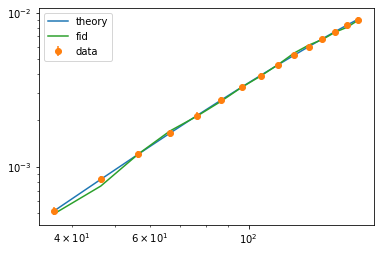

In [46]:
pl.loglog(ell_e[sel],theory(0,1),label='theory')
pl.errorbar(ell_e[sel],cl_data,yerr=len_s[sel]*dl[sel],fmt='o',label='data')
pl.loglog(ell_e[sel], fid*dl[sel],label='fid')
pl.legend()

In [47]:
def log_prior(theta):
    r,alens = theta
    if  -0.5 < r < 0.5 and 0 < alens <2.:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp  -.5 * lh(theta)

In [57]:
nsamples = 10000
pos = np.array([0.0,1]) + 1e-4 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, nsamples,progress=True)

In [61]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

<Figure size 576x576 with 0 Axes>

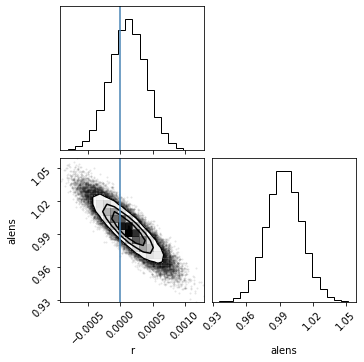

In [62]:
labels = ['r','alens']
pl.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels,truths=[0,0])

In [63]:
r_samp = np.sort(flat_samples[:,0])
r_pos = r_samp[r_samp>0]

In [64]:
print(f"{r_pos[int(len(r_pos)*.683)]:.2e}")

3.45e-04


In [52]:
def myLog(r,Alens):
    return log_probability([r,Alens])

info = {"likelihood": {"like": myLog}}

In [53]:
info["params"] = {
    "r": {"prior": {"min": -.5, "max": .5}, "ref": 0, "proposal": 0.01,"latex":"r"},
    "Alens": {"prior": {"min": 0, "max": 1.5}, "ref": 1, "proposal": 0.01,"latex":"A_{lens}"}}

In [54]:
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

from cobaya.run import run
updated_info, sampler = run(info)

[like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {like: 3250.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: r:0, Alens:1
[mcmc] Sampling!
[mcmc] Progress @ 2021-09-11 04:10:03 : 1 steps taken, and 0 accepted.


/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.013
[mcmc]  - Convergence of means: R-1 = 0.520082 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.030
[mcmc]  - Convergence of means: R-1 = 0.239379 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.057
[mcmc]  - Convergence of means: R-1 = 0.023679 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.105
[mcmc]  - Convergence of means: R-1 = 0.072420 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.354
[mcmc]  - Convergence of means: R-1 = 0.040770 after 320 

[root] *WARNING* outlier fraction 0.0013966480446927375 


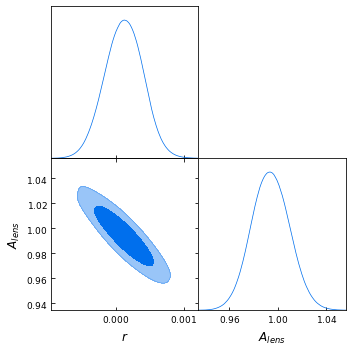

In [55]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["r", "Alens"], filled=True)
pl.savefig('lensed_cobaya.png',bbox_inches='tight')

In [56]:
print(gdsamples.getLikeStats())

Best fit sample -log(Like) = 0.447579
Ln(mean 1/like) = 2.710121
mean(-Ln(like)) = 1.433536
-Ln(mean like)  = 1.132331

parameter    bestfit        lower1         upper1         lower2         upper2
r            1.1979697E-04 -3.0334185E-04  5.3984136E-04 -5.6658735E-04  7.9961026E-04   r
Alens        9.9398204E-01  9.7071370E-01  1.0177086E+00  9.5634500E-01  1.0329368E+00   A_{lens}
chi2*        8.4227490E-02  8.4227490E-02  2.3354359E+00  8.4227490E-02  6.0162251E+00   \chi^2
chi2__like*  8.4227490E-02  8.4227490E-02  2.3354359E+00  8.4227490E-02  6.0162251E+00   \chi^2_\mathrm{like}



In [56]:
r = np.linspace(-.001,.001,100)

In [57]:
logp_ = [myLog(i,1) for i in r]

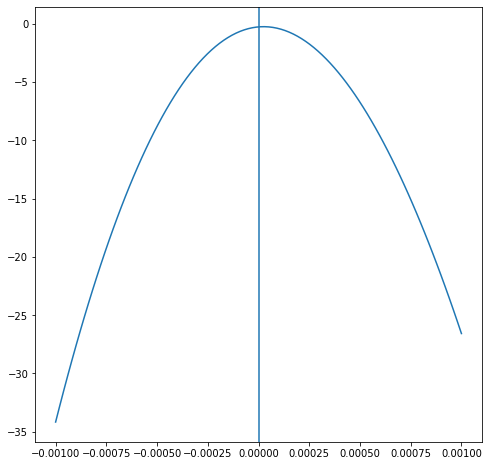

In [58]:
pl.figure(figsize=(8,8))
pl.plot(r,logp_)
pl.axvline(0)